In [13]:
import pickle
import sys
from collections import defaultdict
import csv
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.dummy import DummyClassifier


In [14]:
def rawToVector(text):
    '''
    :param text: texto del csv
    :return: texto sin caracteres raros, espacios, numeros... en BoW
    '''
    res = text

    # Convertir a minusculas
    text = [entry.lower() for entry in text]

    # Convertir texto en array de strings
    text = [word_tokenize(entry) for entry in text]

    # Eliminar palabras raras
    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    for ind, entry in enumerate(text):
        textAux = []
        wl = WordNetLemmatizer()
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word.isalpha():
                wordAux = wl.lemmatize(word, tag_map[tag[0]])
                textAux.append(wordAux)
        res[ind] = str(textAux)

    return res

In [15]:

def loadData(file):

    with open(file, encoding="utf8") as csvFile:
        reader = csv.reader(csvFile, delimiter=",", quotechar='"')
        id = []
        text = []
        label = []
        for row in reader:
            id.append(row[0])  # Añadir los ID
            text.append(row[1])  # Añadir las preguntas
            label.append(row[2])  # Indicar la clasificación de cada pregunta
        return id[1:], text[1:], label[1:]



In [16]:
def getDictionary(vector):
    '''
    :param vector: vector Bow
    :return: diccionario
    '''
    dictionary = TfidfVectorizer(max_features=5000)
    dictionary.fit(vector)
    print("Tamaño del diccionario: ", len(dictionary.vocabulary_))
    return dictionary


In [17]:
import gensim
import io
def read_data(fname, tokens_only=False):
    with io.open(fname, encoding="utf-8") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [51]:
def doc2vec():
    data=list(read_data(r'/home/ena/PycharmProjects/posterMineria/data/tokenized.csv'))
    data.pop(0)
    model = gensim.models.doc2vec.Doc2Vec(vector_size=300, window=10, min_count=5, workers=16,alpha=0.025, min_alpha=0.025, epochs=40)
    model.build_vocab(data)
    %time model.train(data, total_examples=model.corpus_count, epochs=40)
    model.infer_vector(['only', 'you', 'can', 'prevent', 'forrest', 'fires']).dtype=float
    ranks = []
    second_ranks = []
    for doc_id in range(len(data)):
        inferred_vector = model.infer_vector(data[doc_id].words)
        sims = model.dv.most_similar([inferred_vector], topn=len(model.docvecs))
        rank = [docid for docid, sim in sims].index(doc_id)
        ranks.append(rank)

        second_ranks.append(sims[1])


    return train(data,model)

In [52]:
import pandas as pd
def train(data,model):
    train = pd.DataFrame(columns = ['id' , 'text'])
    i=0
    for vector in data:
        train.loc[i]=[i,model.infer_vector(vector[0])]
        i=i+1
    return train

In [19]:
def tfidf(vector, dictionary):
    return dictionary.transform(vector)


In [60]:

def classifyMP(x_train, y_train):

    cls = MLPClassifier()

    parameter_space = {
        'hidden_layer_sizes': [50, (50, 50)],
        'random_state': [1],
        'learning_rate_init': 10.0 ** -np.arange(1, 3),
        'verbose': [True],
        'activation': ['identity', 'logistic','relu','tanh'],
        'alpha': 10.0 ** -np.arange(1, 3),
        'tol': [1e-2],
        'early_stopping': [True],
        'solver': ['sgd', 'adam'],
        'learning_rate': ['constant', 'invscaling', 'adaptive']
    }

    clf = GridSearchCV(cls, parameter_space, n_jobs=-1, cv=10, scoring='accuracy')
    print("HA TERMINADO EL GRIDSEARCH")
    clf.fit(x_train, y_train)

In [21]:
def split(data, labels, percent):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=percent, random_state=42)
    return x_train, x_test, y_train, y_test


In [22]:


from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, f1_score, precision_score

def classifyBaseline(x_train, x_test, y_test, y_train):
    cls = DummyClassifier(strategy='stratified', random_state=1)

    results = "************************************" \
              "\nBASELINE TREC-6 CLASSIFIER" \
              "\n************************************"
    results += '\n--> Best parameters:\n' + str(cls.get_params()) + '\n'

    cls.fit(x_train, y_train)
    predictions = cls.predict(x_test)

    results += "\n---------------------------------------"
    results += "\n EVALUATION SCORES"
    results += "\n---------------------------------------"
    results += "\n--> Accuraccy: " + str(accuracy_score(y_test, predictions))
    results += "\n--> F1-Score: " + str(f1_score(y_test, predictions, average='weighted'))
    results += "\n--> Precision: " + str(precision_score(y_test, predictions, average='weighted'))
    results += "\n--> Recall: " + str(precision_score(y_test, predictions, average='weighted')) + '\n'

    results += "\n--> Classification Report: \n" + classification_report(y_test, predictions)

    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(cls, x_test, y_test,
                                     display_labels=['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'HUM'],
                                     cmap=plt.cm.Blues)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
    dibujar(disp.confusion_matrix)
    plt.savefig('/home/ena/Descargas/Text-Mining-Perceptron-7e41798e25108e67a9ed6a36733af22601dd03cc/results')


In [26]:
import matplotlib.pyplot as plt
def dibujar(text):

    plt.plot(text)
    plt.show()


In [55]:

import pdb
def maindoc2vec():
    file = "/home/ena/PycharmProjects/Clustering-TREC6/Datuak/train.csv"
    id, text, labels = loadData(file)
    data= doc2vec()
    x_train, x_test, y_train, y_test = split(data, labels, 0.3)
    classifyBaseline(x_train,x_test,y_test,y_train)


In [56]:
import pdb
def maintfidf():
    file = "/home/ena/PycharmProjects/Clustering-TREC6/Datuak/train.csv"
    id, text, labels = loadData(file)
    data = rawToVector(text)
    dictionary = getDictionary(data)
    data = tfidf(data, dictionary)
    x_train, x_test, y_train, y_test = split(data, labels, 0.3)
    #classifyBaseline(x_train,x_test,y_test,y_train)
    classifyMP(x_train,y_train)

Tamaño del diccionario:  5000
Confusion matrix, without normalization
[[ 0  6  7  9  3  6]
 [ 4 75 91 79 60 58]
 [ 1 81 98 77 51 53]
 [ 2 79 82 78 61 58]
 [ 4 46 60 65 31 45]
 [ 4 51 67 56 44 44]]
Normalized confusion matrix
[[ 0  6  7  9  3  6]
 [ 4 75 91 79 60 58]
 [ 1 81 98 77 51 53]
 [ 2 79 82 78 61 58]
 [ 4 46 60 65 31 45]
 [ 4 51 67 56 44 44]]


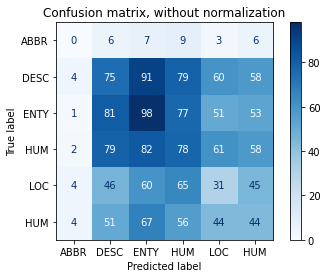

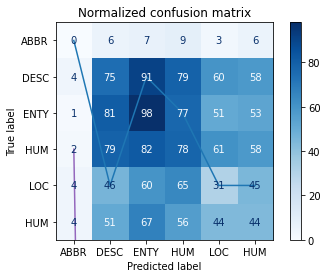

<Figure size 432x288 with 0 Axes>

In [61]:
maintfidf()

CPU times: user 11.9 s, sys: 1.37 s, total: 13.3 s
Wall time: 10.7 s


/home/ena/anaconda3/envs/tia/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  if sys.path[0] == '':


Confusion matrix, without normalization
[[ 0  6  7  9  3  6]
 [ 4 75 91 79 60 58]
 [ 1 81 98 77 51 53]
 [ 2 79 82 78 61 58]
 [ 4 46 60 65 31 45]
 [ 4 51 67 56 44 44]]
Normalized confusion matrix
[[ 0  6  7  9  3  6]
 [ 4 75 91 79 60 58]
 [ 1 81 98 77 51 53]
 [ 2 79 82 78 61 58]
 [ 4 46 60 65 31 45]
 [ 4 51 67 56 44 44]]


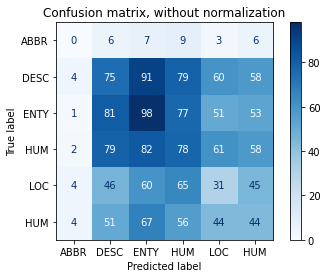

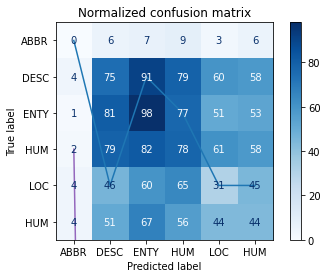

<Figure size 432x288 with 0 Axes>

In [58]:
maindoc2vec()